In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install kaggle

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Segmentation/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle competitions download -c carvana-image-masking-challenge

!unzip -p carvana-image-masking-challenge.zip train.zip >train.zip
!unzip -p carvana-image-masking-challenge.zip train_masks.zip >train_masks.zip

# Unzip the zipped train files.
!unzip train.zip
!unzip train_masks.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train_masks/0789bed99cb8_09_mask.gif  
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gif  
 extracting: t

In [5]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras as ks

In [6]:
def load_data_from_names(root_dir: str, fnames: list, shape=(256, 256)) -> np.array:
    images = []   
    for idx, img_name in enumerate(fnames):
        x = Image.open(os.path.join(root_dir, img_name))
        x = x.resize(shape)
        x = np.array(x)
        images.append(x)
    return np.array(images)

image_names = os.listdir('./train')
mask_names = os.listdir('./train_masks')

image_names.sort()
mask_names.sort()

N = 2000

image_names = image_names[:N]
mask_names = mask_names[:N]

x = load_data_from_names('./train', image_names)
y = load_data_from_names('./train_masks', mask_names)

In [7]:
TRAIN_SIZE = 1800

x_train = x[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]

x_test = x[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

print(f"Train size: {x_train.shape}. Test size: {x_test.shape}")

Train size: (1800, 256, 256, 3). Test size: (200, 256, 256, 3)


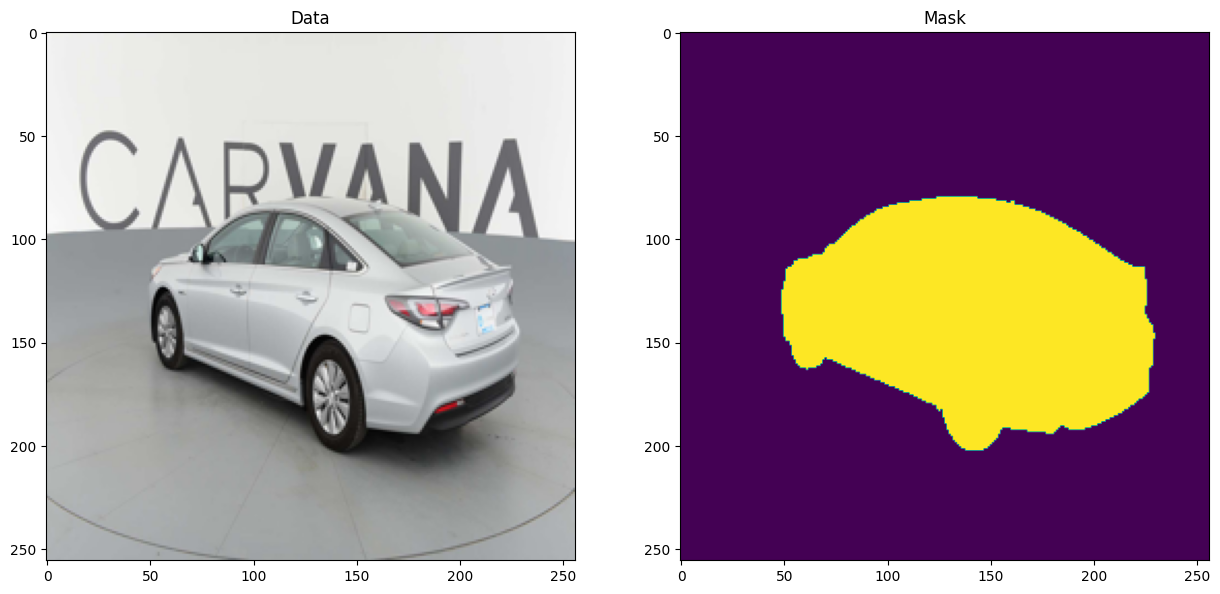

In [9]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

show(x_train[150], y_train[150], title=["Data", "Mask"])

In [31]:
def get_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = ks.layers.Input(shape=input_shape)
    backup_layers = []
    h = x
    for l in range(L):
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)

        if l < L-1: 
            backup_layers.append(h)
            h = ks.layers.MaxPool2D(padding='same')(h)
            n_ch = n_ch * 2
    
    for l in range(L-1):
        n_ch = n_ch // 2
        h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h)
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
    y = ks.layers.Conv2D(1, 1, activation='sigmoid')(h)
    return ks.models.Model(x, y)


In [33]:
unet_model = get_unet((256,256,3))
unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
early_stoppage=ks.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history_unet_model = unet_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[early_stoppage], batch_size=32, epochs=20)

Epoch 1/20
57/57 [==============================] - 40s 564ms/step - loss: 0.4144 - accuracy: 0.8482 - val_loss: 0.2120 - val_accuracy: 0.9159
Epoch 2/20
57/57 [==============================] - 33s 578ms/step - loss: 0.1748 - accuracy: 0.9338 - val_loss: 0.1465 - val_accuracy: 0.9408
Epoch 3/20
57/57 [==============================] - 32s 561ms/step - loss: 0.0991 - accuracy: 0.9622 - val_loss: 0.0869 - val_accuracy: 0.9666
Epoch 4/20
57/57 [==============================] - 32s 569ms/step - loss: 0.0664 - accuracy: 0.9745 - val_loss: 0.0575 - val_accuracy: 0.9776
Epoch 5/20
57/57 [==============================] - 32s 571ms/step - loss: 0.0474 - accuracy: 0.9818 - val_loss: 0.0450 - val_accuracy: 0.9826
Epoch 6/20
57/57 [==============================] - 32s 562ms/step - loss: 0.0420 - accuracy: 0.9839 - val_loss: 0.0378 - val_accuracy: 0.9852
Epoch 7/20
57/57 [==============================] - 32s 566ms/step - loss: 0.0321 - accuracy: 0.9877 - val_loss: 0.0323 - val_accuracy: 0.9873

In [34]:
from keras import backend as K
from keras.losses import binary_crossentropy

def iou_coeff(y_true, y_pred):
    smooth = 1

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection

    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coeff(y_true, y_pred):
    smooth = 1

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def evaluate_model(model, x, y, fun):
    y_pred = model.predict(x)
    y = np.expand_dims(y, -1)

    y_pred = y_pred.astype('float32')
    y = y.astype('float32')

    return fun(y, y_pred)

In [35]:
iou = evaluate_model(unet_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(unet_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 1s 159ms/step
The IoU of the trained model is 0.9568139910697937, while its Dice coefficient is 0.9779616594314575.


In [36]:
y_pred = unet_model.predict(x_test[:1])

1/1 [==============================] - 1s 864ms/step


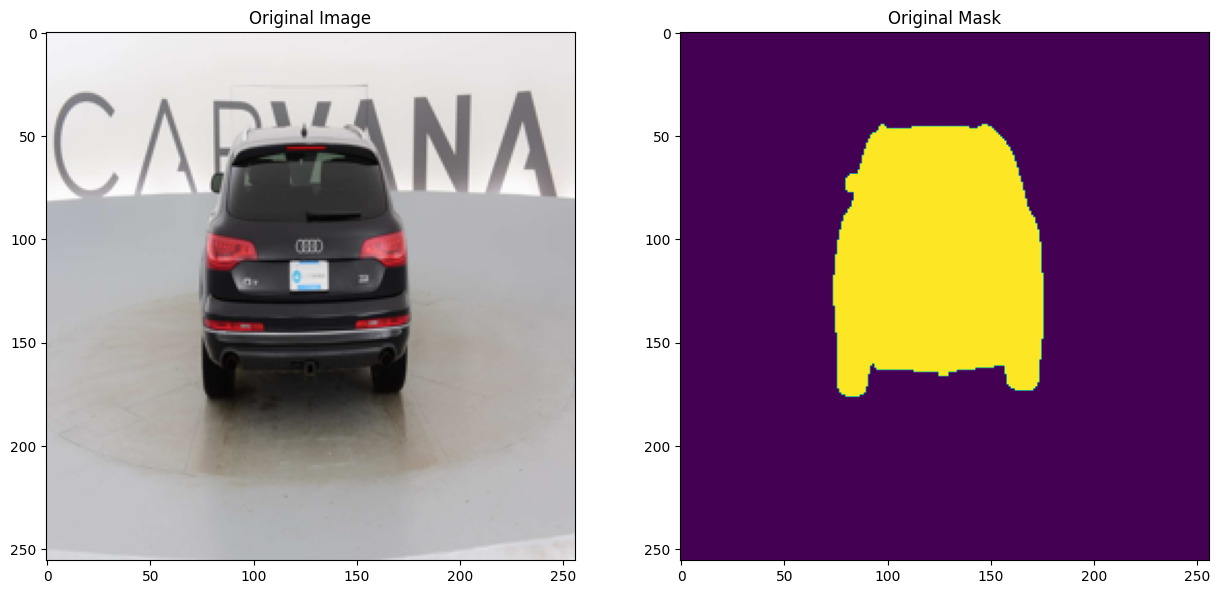

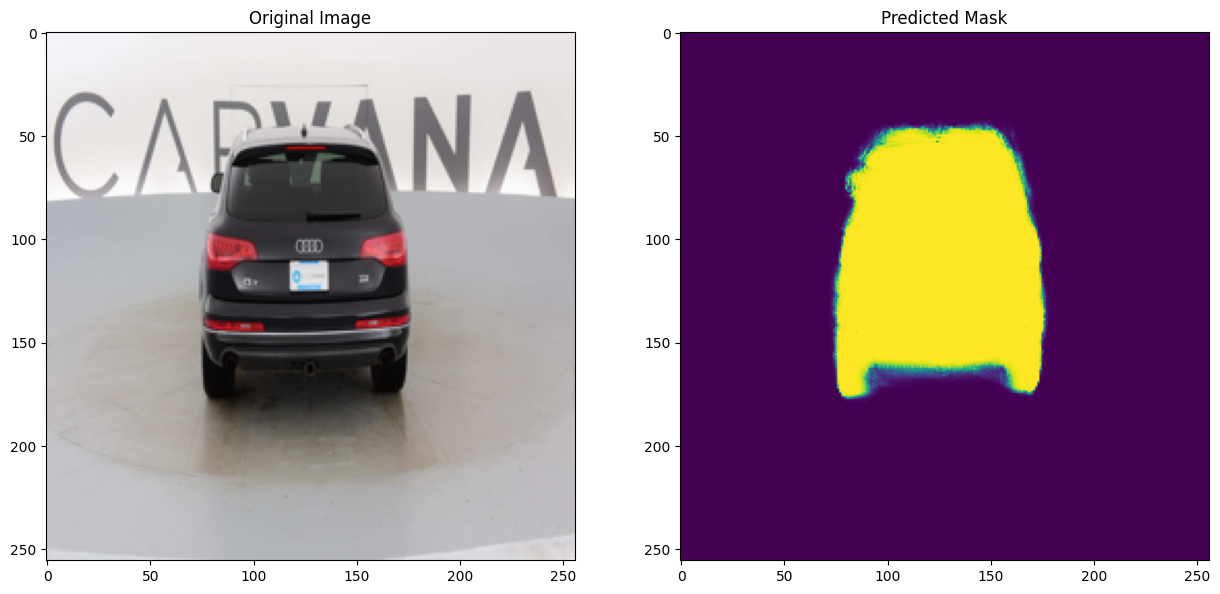

In [37]:
show(x_test[0, :, :], y_test[0, :, :], title=['Original Image', "Original Mask"])
show(x_test[0, :, :], y_pred[0, :, :, 0], title=["Original Image", 'Predicted Mask'])